In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

In [50]:
train = pd.read_csv('train.csv', index_col=0)
bulk = pd.read_csv('machine failure.csv')
bulk = bulk.drop(columns=['UDI'])
train_df = pd.concat([train, bulk], axis=0)
test_df = pd.read_csv("test.csv")

In [51]:
train  = train_df.copy()
features = train.columns.tolist()
# Categorical features
cat_features = ['Product ID', 'Type']
# Binary features
bin_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# Numerical features
num_features = ['Air temperature [K]', 'Process temperature [K]',
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

In [52]:
scaler = StandardScaler()
train_df[num_features] = scaler.fit_transform(train_df[num_features])
test_df[num_features] = scaler.fit_transform(test_df[num_features])

In [53]:
def roc_auc(true_list, pred_list, a, b):
    
    fpr, tpr, _ = roc_curve(true_list, pred_list)    
    roc_auc = auc(fpr, tpr)

    # print(f'FPR: {fpr}')
    # print(f'TPR: {tpr}')
    # print(f'{list(zip(fpr,tpr))}') 
    print(f'\n>>>>> ROC_AUC: %0.6f <<<<<\n' %roc_auc)
    
    sns.set()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(a, b), facecolor='lightgray')
    plt.gca().set_facecolor('lightyellow')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The area under the ROC curve\n')
    plt.legend(loc="lower right")
    plt.show()

In [54]:
def fix_names(df):
    df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
    return df
train_df = fix_names(train_df)
test_df  = fix_names(test_df)
train_df = train_df.drop(['Product ID'] , axis=1)
test_df = test_df.drop(['Product ID'] , axis=1)
features = train_df.columns.tolist()
features.remove('Machine failure')

In [55]:
features

['Type',
 'Air temperature K',
 'Process temperature K',
 'Rotational speed rpm',
 'Torque Nm',
 'Tool wear min',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [56]:
# Categorical features
cat_features = ['Type']
# Binary features
bin_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# Numerical features
num_features = [f for f in features if f not in (cat_features + bin_features)]

In [57]:
train_code = pd.get_dummies(train_df, columns=cat_features)
test_code = pd.get_dummies(test_df, columns=cat_features)
target = train_code.pop('Machine failure')
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))

In [58]:
test_code = test_code.drop(columns=['id'])

In [59]:
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(train_code, target)
cross_val_score(pipeline, train_code, target, scoring='roc_auc', cv=10).mean()

0.9531831607034057


>>>>> ROC_AUC: 0.953796 <<<<<



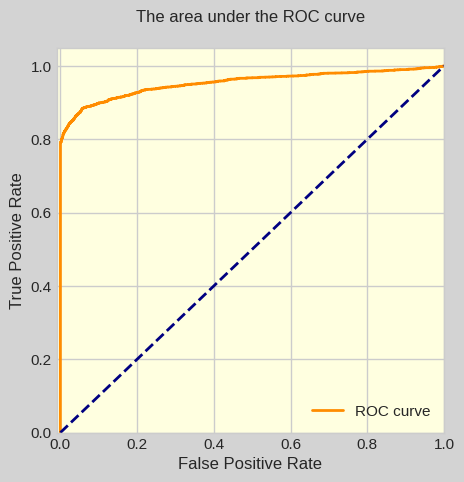

array([3.48162744e-13, 2.42473751e-13, 2.32605417e-13, ...,
       3.54702241e-14, 5.21914935e-14, 4.75298407e-13])

In [60]:
roc_auc(target, pipeline.predict_proba(train_code)[:, 1], 5, 5)
preds_bayes = pipeline.predict_proba(test_code)[:,1]
preds_bayes

In [62]:
df_sample = pd.read_csv('sample_submission.csv')

In [63]:
sub_bayes = df_sample.copy()
sub_bayes['Machine failure'] = preds_bayes
sub_bayes.to_csv('GaussianNB1.csv',index=False)

In [65]:
sub_import1 = pd.read_csv('sample_submission.csv')
sub_import2 = pd.read_csv('sample_submission.csv')

In [66]:
sub = df_sample.copy()
sub['Machine failure'] = (0.20 * sub_bayes['Machine failure']) + (0.20 * sub_import1['Machine failure']) + (0.60 * sub_import2['Machine failure'])
sub.to_csv('GaussianNB2.csv',index=False)